#Deep Learning for Healthcare -- Team 44<br>
Replicated Paper: An attention based deep learning model of clinical events in the intensive care unit<br>
<br>
Github Repo: https://github.com/jgbyc/DL4H_Team_44.git
<br>
Video Presentation: https://drive.google.com/file/d/1G8j2mwtLJ3NJnFOdu_ZgMmPizkmlzuM4/view?usp=sharing
<br><br>
Kun Ren (kunren2@illinois.edu)<br>
Yichen Bi (ybi5@illinois.edu)

#Introduction
* Background of the problem
  * What type of problem?<br>
  Develop and implement predictive models and computer assisted diagnostic (CAD) solutions that are interpretable, generalizable, and able to predict important clinical outcomes to aid in clinical care and provide high level supportive analytics for intensive care units (ICUs)<br><br>
  * What is the importance/meaning of solving the problem?<br>
  It is important to prevent information overload to ensure safe and efficient delivery of patient care. Reducing information overload is associated with more rapid care with fewer errors.<br><br>
  * What is the difficulty of the problem?<br>
  Traditional deep learning models are difficult to implement due to their reliance on large datasets which are rare in healthcare. Moreover, these models often exhibit limited interpretability, which have driven the adoption of transparent linear models.<br><br>
  * The state-of-the-art methods and effectiveness.
  Two popular methods are available: <br>
  Scoring system. Scoring methods are usually trained on one outcome and their effectiveness will be significantly compromised when utilized for another for which they were not designed.<br>
  Traditional RNN models. Despite the strength of RNN models, their model interpretability are generally low. <br><br>
* Paper explanation
  * What did the paper propose?<br>
   The paper “An attention based deep learning model of clinical events in the intensive care unit” explores the application of advanced deep learning techniques to the critical field of healthcare. It introduces a model that employs Long Short-Term Memory (LSTM) networks enhanced with an attention mechanism to analyze clinical events within the ICU setting. The model is trained on the MIMIC-III dataset, aiming to predict the daily likelihood of sepsis, myocardial infarction, and the need for vancomycin antibiotic administration3.

  * What is the innovations of the method?<br>
  The paper uses a Long Short-Term Memory (LSTM) networks enhanced with an attention mechanism. This enhanced mechanism can significantly improve the model interpretability.

  * How well the proposed method work (in its own metrics)?<br>
  The AUC of same-day myocardial ischemia, sepsis and vancomycin administration are 0.834, 0.952 and 0.904 respectively.

  * What is the contribution to the research regime?<br>
  The contribution of this paper is twofold:<br>
  Innovative Use of Attention Mechanism: It leverages the attention mechanism to provide insights into which clinical data points are most influential in predicting outcomes, thereby offering a layer of interpretability often missing in complex models.<br>
  Clinical Decision Support: By accurately predicting critical clinical events, the model has the potential to serve as a decision support tool, helping to manage the vast amount of data ICU physicians must process, and ultimately improving patient care outcomes.<br>
  This paper stands out for its potential impact on the healthcare industry, providing a pathway towards more informed and data-driven clinical decisions in high-stakes ICU environments.


# Mount Notebook to Google Drive and Change the Workspace Folder
In order to run this notebook, preprocessed data in Pickled objects and pretrained models must be stored under folder Colab_notebooks in Google Drive.

Below is the required file/folder structure. The required folders and files can be acquired from the Github repository.<br>


Colab_notebooks<br>
├── pickled_objects<br>
├── saved_models<br>
├── discussion_results_figures<br>
├── keract.py<br>

This step will mount the notebook to Google Drive and change the Workspace to Colab_notebooks folder.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

Mounted at /content/drive/


In [2]:
import gc
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
from seaborn import heatmap
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis

# To visulize the attention layers and generate its heatmap, Keract module is imported from https://github.com/philipperemy/keract
import keract

# plot part.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Show inline picture in Google Colab
import cv2
from google.colab.patches import cv2_imshow

# Scope of Reproducibility:
The original paper performs three experiments onmyocardial infarction, sepsis and vancomycin administration respectively with the same model strucuture. Due to the 8 min code running time limits, we will only reproduce and present the model results for vancomycin administration target.


1. Hypothesis 1: The LSTM-based model with an attention mechanism can accurately predict daily clinical event vancomycin administration in the ICU.
2. Hypothesis 2: The attention mechanism within the model provides interpretability by highlighting influential input variables that impact the model’s predictions.

3. Experiment 1: Replicate the model training using the MIMIC-III dataset to predict the daily occurrence of vancomycin administration. The performance will be measured using the area under the receiver operating characteristic curve (AUC).

4. Experiment 2: Generate attention maps to identify the variables that the model attends to most when making predictions. This will test the model’s interpretability and its potential utility for clinicians.

# Methodology

##  Enviroment

Python version: 3.8.4

Packages installed:

* numpy 1.24.3

* pandas 2.0.3

* scikit-learn 1.3.2

* seaborn 0.13.2

* matplotlib 3.7.5

* keras version: 2.13.1

* tensorflow version : 2.13.0


##  Data

### Source of the data
Our dataset was constructed by processing the MIMIC III Clinical Dataset. We have finished the training and been provided the access to the MIMIC III database.

In [3]:
# Load the pre_processed MIMIC III data.
X_TRAIN_VANCOMYCIN = pickle.load(open('./pickled_objects/X_TRAIN_VANCOMYCIN.txt', 'rb'))
Y_TRAIN_VANCOMYCIN = pickle.load(open('./pickled_objects/Y_TRAIN_VANCOMYCIN.txt', 'rb'))

Y_VAL_VANCOMYCIN = pickle.load(open('./pickled_objects/Y_VAL_VANCOMYCIN.txt', 'rb'))
X_VAL_VANCOMYCIN = pickle.load(open('./pickled_objects/X_VAL_VANCOMYCIN.txt', 'rb'))

Y_TEST_VANCOMYCIN = pickle.load(open('./pickled_objects/Y_TEST_VANCOMYCIN.txt', 'rb'))
X_TEST_VANCOMYCIN = pickle.load(open('./pickled_objects/X_TEST_VANCOMYCIN.txt', 'rb'))

y_boolmat_test_VANCOMYCIN = pickle.load(open('./pickled_objects/y_boolmat_test_VANCOMYCIN.txt', 'rb'))
x_boolmat_test_VANCOMYCIN = pickle.load(open('./pickled_objects/x_boolmat_test_VANCOMYCIN.txt', 'rb'))

no_features_cols_VANCOMYCIN = pickle.load(open('./pickled_objects/no_feature_cols_VANCOMYCIN.txt', 'rb'))
features_VANCOMYCIN = pickle.load(open('./pickled_objects/features_VANCOMYCIN.txt', 'rb'))


my_cmap= sns.cubehelix_palette(14, as_cmap=True)
color_list = sns.cubehelix_palette(14)
color_list_reduced = sns.cubehelix_palette(7)
X_TRAIN = X_TRAIN_VANCOMYCIN
X_VAL = X_VAL_VANCOMYCIN
Y_TRAIN = Y_TRAIN_VANCOMYCIN
Y_VAL = Y_VAL_VANCOMYCIN
Y_TEST = Y_TEST_VANCOMYCIN
X_TEST = X_TEST_VANCOMYCIN
y_boolmat_test = y_boolmat_test_VANCOMYCIN
x_boolmat_test = x_boolmat_test_VANCOMYCIN
features = features_VANCOMYCIN

Y_TOTAL = np.concatenate([Y_TRAIN, Y_VAL, Y_TEST], axis=0)

### Statistics:


In [4]:
target = 'VANCOMYCIN'

In [5]:
# Show total number of VANCOMYCIN labels
Y_VANCOMYCIN = np.concatenate([Y_TRAIN_VANCOMYCIN, Y_VAL_VANCOMYCIN], axis=0)
print(np.sum(np.sum(Y_VANCOMYCIN.squeeze(), axis=1) > 0))

16604


In [6]:
# Show number of training dataset used for VANCOMYCIN administrtion
#print(no_features_cols_VANCOMYCIN)

print(X_TRAIN_VANCOMYCIN.shape)

(29128, 14, 223)


<Axes: title={'center': 'Number of total patients positive on a given day'}, xlabel='Day', ylabel='Number of total patients with VANCOMYCIN'>

<Figure size 640x480 with 0 Axes>

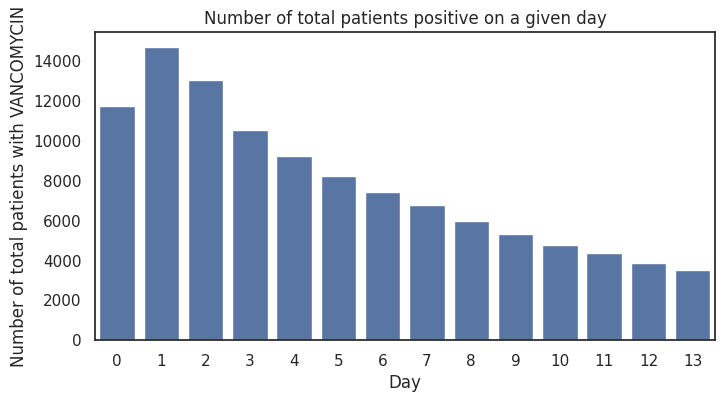

In [7]:
# number of people who are positive on a given day
sns.set(style="white")
sns.despine(left=True, bottom=True)

plt.figure(figsize = (8,4))
plt.title('Number of total patients positive on a given day')
plt.ylabel('Number of total patients with {0}'.format(target))
plt.xlabel('Day')
y_vector_total = np.nansum(Y_TOTAL, axis=0).squeeze()
color_rank = np.argsort(np.argsort(y_vector_total))
sns.barplot(y=y_vector_total, x=np.arange(14))

# plt.savefig('./figures/{0}_Total_Patients_Positive_Supplemental_Figure_1.eps'.format(target), format='eps',
#              dpi=300, bbox_inches='tight')

### Data Process:
Individual patient ICU admissions 2 days or longer were identified. ICU stays longer than 14 days were truncated to the first 14 days. When a patient’s stay was fewer than 14 days, extra days were masked out with 0 in training.

The target variables are constructed when receipt of any dose of vancomycin.<br>
Predictor are similarly constructed and variables whose more than 75% values are missing are excluded. Totally, 119 features are selected for the modeling purpose. These 119 features are processed into 225 variables by using statistical conversions (average, max, min, std).<br><br>

The data have been preprocessed offline and the processed data are stored in pickle formats under pickled_objects folder

##   Model and Training

In original paper, the RNN model was implemented. 3-dimensional data
with patient ICU stays (n = 56,841), time steps (n = 14), and features (n<=225) are served as input
to the attention layer described above. This input layer feeds into an attention layer that weights
the inputs. This weighted input layer is fed to a masking layer to contend with masked
sequences when patients have ICU stays less than 14 days. Finally, the output of the masking
layer is fed directly to the LSTM layer. An LSTM layer with 256 units was connected to a
hyperbolic tangent activation function. The output of the network architecture features one
dense neuron with a softmax activation to output the probability of a given event over each
day of an ICU stay. Activation maps consisting of the raw softmax activations ak for each input
variable k were obtained from the attention layer of the RNN for the purposes of interpreting
model outputs.

Oringinal paper's repo can be found from below link.
https://github.com/deepak-kaji/mimic-lstm


### Model Architecture
Input -> Attention Layers -> Masking Layers -> 256 Units LSTM Layers -> Time Distributed Layers -> Fully Connected Layer (Sigmoid Activation)

### Training Objectives
The model uses:<br>
* Optimizer that implements the RMSprop algorithm.
* Loss function that implements binary cross entropy.

### Hyperparams
RNNs were trained with a RMSProp
optimizer with a learning rate of 0.001, rho of 0.9, epsilon of 1e-08 and no decay were used in all models.<br>

### Hardware used for training
* CPU: i9-12900K
* RAM: 64 GB

### Computational requirements
Model is trained for 14 epochs with a batch size of 16. Total training CPU time is 1 hour and 10 mins.

Training Code rnn_mimic.py can be found in Github repo https://github.com/jgbyc/DL4H_Team_44.git

### Pre-trained models
Due to the 8 min notebook running limits, the model is trained outside the notebook and store in the folder saved_models.



In [8]:
TIME_STEPS = X_VAL.shape[1] #number of time_steps

In [9]:
#function to load the pre-trained models
def return_loaded_model(model_name):
  loaded_model = load_model("./saved_models/{0}.h5".format(model_name))
  return loaded_model

In [10]:
# The models are trained offline. Here we load the model from Google Drive
# Models trained with various fractions of training data
m = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14")
m_80 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_80_percent")
m_60 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_60_percent")
m_40 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_40_percent")
m_20 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_20_percent")
m_10 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_10_percent")
m_5 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_5_percent")

# Evaluation and Results
The results includes two parts
* AUC Results to show the model accuracy.
* Heatmap to visulize the attention weights on each features on each day.


## AUC Results


### AUC results for models trained with various fractions of data


In [11]:
# Finish the prediction by using the test data and pre-trained models
X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_mask_0 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_80_percent = m_80.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_60_percent = m_60.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_40_percent = m_40.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_20_percent = m_20.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_10_percent = m_10.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_5_percent = m_5.predict(X_TEST_MASK)
del X_TEST_MASK

342/342 [==============================] - 12s 29ms/step


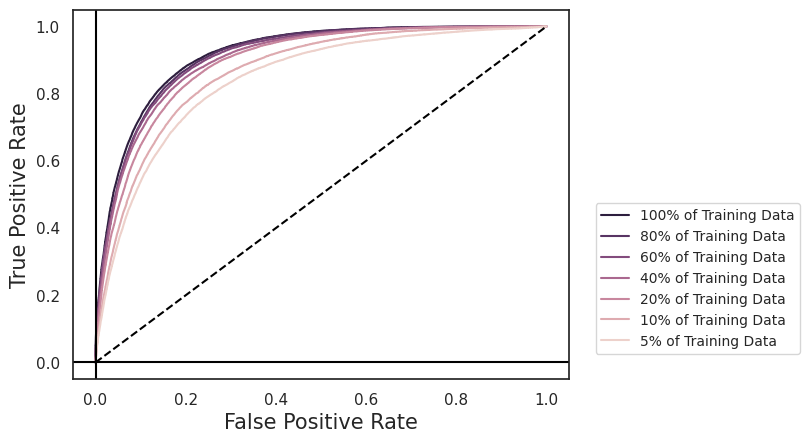

In [12]:
# Generate the ROC curve for models trained with various fractions of training data.
(fpr_100, tpr_100, thresholds_100) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test])
(fpr_80, tpr_80, thresholds_80) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_80_percent[~y_boolmat_test])
(fpr_60, tpr_60, thresholds_60) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_60_percent[~y_boolmat_test])
(fpr_40, tpr_40, thresholds_40) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_40_percent[~y_boolmat_test])
(fpr_20, tpr_20, thresholds_20) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_20_percent[~y_boolmat_test])
(fpr_10, tpr_10, thresholds_10) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_10_percent[~y_boolmat_test])
(fpr_5, tpr_5, thresholds_5) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_5_percent[~y_boolmat_test])

fpr_tprs = [(fpr_100, tpr_100), (fpr_80, tpr_80), (fpr_60, tpr_60),
            (fpr_40, tpr_40), (fpr_20, tpr_20), (fpr_10, tpr_10), (fpr_5, tpr_5)]

fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[::-1], fpr_tprs, [100,80,60,40,20,10,5]):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0}% of Training Data'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.48, 0.05))
# plt.savefig('./figures/{0}_less_data_roc_curves_Supplemental_Figure_2.svg'.format(target), format='svg',
#              dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [13]:
# Print AUC score for models with various fractions of training data.
print('The AUC score of 100% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test])))
print('The AUC score of 80% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_80_percent[~y_boolmat_test])))
print('The AUC score of 60% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_60_percent[~y_boolmat_test])))
print('The AUC score of 40% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_40_percent[~y_boolmat_test])))
print('The AUC score of 20% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_20_percent[~y_boolmat_test])))
print('The AUC score of 10% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_10_percent[~y_boolmat_test])))
print('The AUC score of  5% data is {0}'.format(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_5_percent[~y_boolmat_test])))
print('\n')

# Compute the metrics for model trained with 100% data
TN, FP, FN, TP = confusion_matrix(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])).ravel()
PPV = TP/(TP+FP)
print("PPV for full model is {0}".format(PPV))
CR = classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print("Sensitivity for full model is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])))

The AUC score of 100% data is 0.9169751115234768
The AUC score of 80% data is 0.9118609172626486
The AUC score of 60% data is 0.9088398084960237
The AUC score of 40% data is 0.9020525562414938
The AUC score of 20% data is 0.8912759169716898
The AUC score of 10% data is 0.8641624906930683
The AUC score of  5% data is 0.8425561604063853


PPV for full model is 0.7225642212450821
Sensitivity for full model is 0.70
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     67236
         1.0       0.72      0.70      0.71     22146

    accuracy                           0.86     89382
   macro avg       0.81      0.81      0.81     89382
weighted avg       0.86      0.86      0.86     89382



### AUC results for models when last certain days data are hidden.
Reported AUCs were calculated for targets over all available days weighted equally (up to 14). Then the last day’s prediction inputs were hidden while predictions were still made on all possible days. This continued until all but the first day’s predictor inputs were hidden (‘Day 1’), and predictions were still made for all possible days

In [14]:
##############
## FIGURE 1 ##
##############

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_mask_0 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 1
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_1 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 2
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_2 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 3
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_3 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 4
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_4 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 5
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_5 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 6
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_6 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 7
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_7 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 8
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_8 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 9
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_9 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 10
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_10 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 11
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_11 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 12
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_12 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 13
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_13 = m.predict(X_TEST_MASK)
del X_TEST_MASK

342/342 [==============================] - 9s 25ms/step


In [15]:
##############
## FIGURE 1 ##
##############

(fpr_mask_0, tpr_mask_0, thresholds_mask_0) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test])
(fpr_mask_1, tpr_mask_1, thresholds_mask_1) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_1[~y_boolmat_test])
(fpr_mask_2, tpr_mask_2, thresholds_mask_2) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_2[~y_boolmat_test])
(fpr_mask_3, tpr_mask_3, thresholds_mask_3) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_3[~y_boolmat_test])
(fpr_mask_4, tpr_mask_4, thresholds_mask_4) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_4[~y_boolmat_test])
(fpr_mask_5, tpr_mask_5, thresholds_mask_5) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_5[~y_boolmat_test])
(fpr_mask_6, tpr_mask_6, thresholds_mask_6) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_6[~y_boolmat_test])
(fpr_mask_7, tpr_mask_7, thresholds_mask_7) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_7[~y_boolmat_test])
(fpr_mask_8, tpr_mask_8, thresholds_mask_8) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_8[~y_boolmat_test])
(fpr_mask_9, tpr_mask_9, thresholds_mask_9) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_9[~y_boolmat_test])
(fpr_mask_10, tpr_mask_10, thresholds_mask_10) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_10[~y_boolmat_test])
(fpr_mask_11, tpr_mask_11, thresholds_mask_11) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_11[~y_boolmat_test])
(fpr_mask_12, tpr_mask_12, thresholds_mask_12) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_12[~y_boolmat_test])
(fpr_mask_13, tpr_mask_13, thresholds_mask_13) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_13[~y_boolmat_test])

fpr_tprs = [(fpr_mask_1, tpr_mask_1), (fpr_mask_2, tpr_mask_2), (fpr_mask_3, tpr_mask_3), (fpr_mask_4, tpr_mask_4),
            (fpr_mask_5, tpr_mask_5), (fpr_mask_6, tpr_mask_6), (fpr_mask_7, tpr_mask_7), (fpr_mask_8, tpr_mask_8),
            (fpr_mask_9, tpr_mask_9), (fpr_mask_10, tpr_mask_10), (fpr_mask_11, tpr_mask_11), (fpr_mask_12, tpr_mask_12),
            (fpr_mask_13, tpr_mask_13), (fpr_mask_0, tpr_mask_0)]

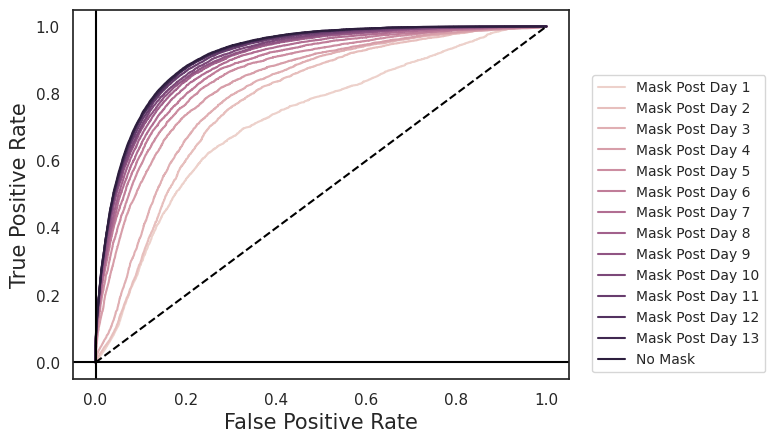

In [16]:
##############
## FIGURE 1 ##
##############

fig, ax = plt.subplots()
ax.set_facecolor('white')

counter = 1

for color, fpr_tpr_tuple in zip(color_list, fpr_tprs):
    if counter != 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='Mask Post Day {0}'.format(counter), color=color)
        counter = counter+1
    elif counter == 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='No Mask', color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.41, 0))
# plt.savefig('./figures/{0}_roc_curves_Fig_1.eps'.format(target), format='eps',
#              dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

### AUC scores for next-day predictive performance over each time step

AUC scores are calculated to visualize next-day classification performance over each time step. Only Day 1 predictors were made available, and predictive AUC was calculated for Day 2; then Day 1 and 2 predictors were made available, and predictive AUC was calculated for Day 3; this procedure was followed to make next-day predictions for up to 13 timesteps.

In [17]:
##############################
## FIGURE 2 LAG EXPERIMENTS ##
##############################

### 1 DAY LAGGED EXPERIMENTS ###

### Y_PRED_mask_0_LAG_1 ###

Y_PRED_mask_0_LAG_1 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(1,13)], axis=0)
Y_PRED_mask_0_LAG_2 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(2,13)], axis=0)
Y_PRED_mask_0_LAG_3 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(3,13)], axis=0)
Y_PRED_mask_0_LAG_4 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(4,13)], axis=0)
Y_PRED_mask_0_LAG_5 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(5,13)], axis=0)
Y_PRED_mask_0_LAG_6 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(6,13)], axis=0)
Y_PRED_mask_0_LAG_7 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(7,13)], axis=0)

### all the first day soft every person, all the second days, third days, in a 1D vector

Y_TEST_LAG_1 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(1,14)], axis=0)
Y_TEST_LAG_2 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(2,14)], axis=0)
Y_TEST_LAG_3 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(3,14)], axis=0)
Y_TEST_LAG_4 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(4,14)], axis=0)
Y_TEST_LAG_5 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(5,14)], axis=0)
Y_TEST_LAG_6 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(6,14)], axis=0)
Y_TEST_LAG_7 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(7,14)], axis=0)

#############
## Y_PREDS ##
#############

Y_PRED_LAG_1 = np.concatenate([Y_PRED_mask_1[:,1,::][~y_boolmat_test[:,1,::]],
                             Y_PRED_mask_2[:,2,::][~y_boolmat_test[:,2,::]],
                             Y_PRED_mask_3[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_4[:,4,::][~y_boolmat_test[:,4,:]],
                             Y_PRED_mask_5[:,5,::][~y_boolmat_test[:,5,::]],
                             Y_PRED_mask_6[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_7[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_8[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_9[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_10[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_11[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_12[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_13[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_2 = np.concatenate([Y_PRED_mask_1[:,2,::][~y_boolmat_test[:,2,::]],
                             Y_PRED_mask_2[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_3[:,4,::][~y_boolmat_test[:,4,::]],
                             Y_PRED_mask_4[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_5[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_6[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_7[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_8[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_9[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_10[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_11[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_12[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_3 = np.concatenate([Y_PRED_mask_1[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_2[:,4,::][~y_boolmat_test[:,4,::]],
                             Y_PRED_mask_3[:,5,::][~y_boolmat_test[:,5,::]],
                             Y_PRED_mask_4[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_5[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_6[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_7[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_8[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_9[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_10[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_11[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_4 = np.concatenate([Y_PRED_mask_1[:,4,::][~y_boolmat_test[:,4,:]],
                             Y_PRED_mask_2[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_3[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_4[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_5[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_6[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_7[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_8[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_9[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_10[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_5 = np.concatenate([Y_PRED_mask_1[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_2[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_3[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_4[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_5[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_6[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_7[:,11,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_8[:,12,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_9[:,13,::][~y_boolmat_test[:,12,::]]], axis=0)

Y_PRED_LAG_5 = np.concatenate([Y_PRED_mask_1[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_2[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_3[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_4[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_5[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_6[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_7[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_8[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_9[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_6 = np.concatenate([Y_PRED_mask_1[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_2[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_3[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_4[:,9,::][~y_boolmat_test[:,9,:]],
                             Y_PRED_mask_5[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_6[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_7[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_8[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_7 = np.concatenate([Y_PRED_mask_1[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_2[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_3[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_4[:,10,::][~y_boolmat_test[:,10,:]],
                             Y_PRED_mask_5[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_6[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_7[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

In [18]:
(fpr_mask_1, tpr_mask_1, thresholds_mask_1) = roc_curve(Y_TEST_LAG_1, Y_PRED_LAG_1)
(fpr_mask_2, tpr_mask_2, thresholds_mask_2) = roc_curve(Y_TEST_LAG_2, Y_PRED_LAG_2)
(fpr_mask_3, tpr_mask_3, thresholds_mask_3) = roc_curve(Y_TEST_LAG_3, Y_PRED_LAG_3)
(fpr_mask_4, tpr_mask_4, thresholds_mask_4) = roc_curve(Y_TEST_LAG_4, Y_PRED_LAG_4)
(fpr_mask_5, tpr_mask_5, thresholds_mask_5) = roc_curve(Y_TEST_LAG_5, Y_PRED_LAG_5)
(fpr_mask_6, tpr_mask_6, thresholds_mask_6) = roc_curve(Y_TEST_LAG_6, Y_PRED_LAG_6)
(fpr_mask_7, tpr_mask_7, thresholds_mask_7) = roc_curve(Y_TEST_LAG_7, Y_PRED_LAG_7)

fpr_tprs = [(fpr_mask_1, tpr_mask_1), (fpr_mask_2, tpr_mask_2), (fpr_mask_3, tpr_mask_3), (fpr_mask_4, tpr_mask_4),
            (fpr_mask_5, tpr_mask_5), (fpr_mask_6, tpr_mask_6), (fpr_mask_7, tpr_mask_7), (fpr_mask_8, tpr_mask_8),
            (fpr_mask_9, tpr_mask_9), (fpr_mask_10, tpr_mask_10), (fpr_mask_11, tpr_mask_11), (fpr_mask_12, tpr_mask_12),
            (fpr_mask_13, tpr_mask_13), (fpr_mask_0, tpr_mask_0)]

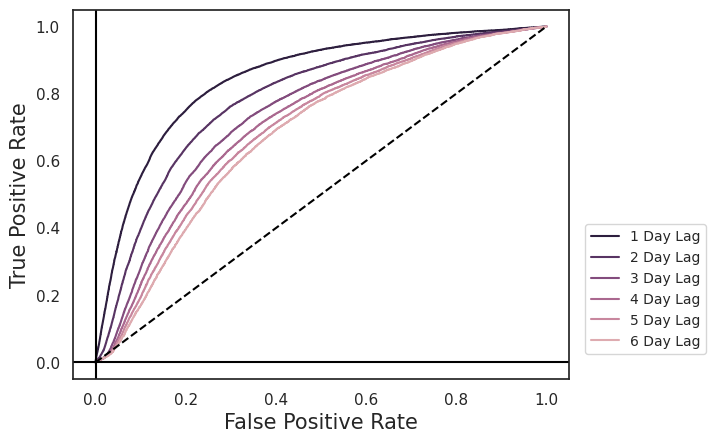

In [19]:
fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[-1:0:-1], fpr_tprs, range(1,8)):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0} Day Lag'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.29, 0.05))
# plt.savefig('./figures/{0}_lagged_roc_curves_Fig_2.eps'.format(target), format='eps',
#              dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [20]:
## LAG ROC ##

# Day 1 Lag
print('The AUC score of Day 1 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_1, Y_PRED_LAG_1)))
# Day 2 Lag
print('The AUC score of Day 2 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_2, Y_PRED_LAG_2)))
# # Day 3 Lag
print('The AUC score of Day 3 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_3, Y_PRED_LAG_3)))
# Day 4 Lag
print('The AUC score of Day 4 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_4, Y_PRED_LAG_4)))
# Day 5 Lag
print('The AUC score of Day 5 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_5, Y_PRED_LAG_5)))
# Day 6 Lag
print('The AUC score of Day 6 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_6, Y_PRED_LAG_6)))
# Day 6 Lag
print('The AUC score of Day 7 lag is {0}'.format(roc_auc_score(Y_TEST_LAG_7, Y_PRED_LAG_7)))

confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

## 100% Training Data with 1 day lag ##
TN, FP, FN, TP = confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)).ravel()
PPV = TP/(TP+FP)
print("PPV for full model w/ 1 day lag is {0}".format(PPV))
CR = classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

print("Sensitivity for full model w/ 1 day lag is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)))

The AUC score of Day 1 lag is 0.8440500678814264
The AUC score of Day 2 lag is 0.7844733288304283
The AUC score of Day 3 lag is 0.7373958547690203
The AUC score of Day 4 lag is 0.7114033724357055
The AUC score of Day 5 lag is 0.6932073966715533
The AUC score of Day 6 lag is 0.6781182262258931
The AUC score of Day 7 lag is 0.6649225920005815
PPV for full model w/ 1 day lag is 0.6303030303030303
Sensitivity for full model w/ 1 day lag is 0.60
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     58721
         1.0       0.63      0.60      0.62     19742

    accuracy                           0.81     78463
   macro avg       0.75      0.74      0.74     78463
weighted avg       0.81      0.81      0.81     78463



## Heatmap
Generate the heatmap to visulize the attention weights on each features on each day.

In [21]:
# GET ACTIVATIONS MATRIX ; OUTPUT IS (BATCH_SIZE, TIME_STEPS, FEATURES)

activations = keract.get_activations(m, X_TEST, output_format='simple', layer_names='attention_vec')['attention_vec']
activations[x_boolmat_test] = np.nan

# AVERAGE THE ATTENTION MATRIX OVER FEATURES ; OUTPUT IS BATCH_SIZE, TIME_STEPS
attention_matrix = np.nanmean(activations, axis=2).squeeze()

# AVERAGE ATTENTION VECTOR ACROSS SAMPLES ; OUTPUT IS 1D TIME_STEPS
attention_vector_final = np.nanmean(attention_matrix, axis=0)

# This allows us to rank color intensity by activation. We sort the intensities, then argsort the indices ##
color_order = np.argsort(attention_vector_final, axis=0)
color_order_order = np.argsort(color_order)

<ipython-input-21-23c908b187c4>:7: RuntimeWarning: Mean of empty slice
  attention_matrix = np.nanmean(activations, axis=2).squeeze()


In [22]:
''' Due to the way features are selectd from the EMR and the fact potassium can be a
delivered medication or a lab value, special care was taken to ensure proper representation on heatmaps '''

if 'digoxin(?!.*fab)' in features:
    indexy = features.index('digoxin(?!.*fab)')
    features[indexy] = 'digoxin'

if 'potassium_y' in features:
    indexy = features.index('potassium_y')
    features[indexy] = 'potassium_med'

if 'potassium_x' in features:
    indexy = features.index('potassium_x')
    features[indexy] = 'potassium'

if 'cipfloxacin' in features:
    indexy = features.index('cipfloxacin')
    features[indexy] = 'ciprofloxacin'

features = [feature.lower() for feature in features]

In [23]:
## FEATURES BY CATEGORY ##

cbc_diff_features = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit',
                              'atypical lymphocytes', 'bands', 'basophils', 'eosinophils', 'neutrophils',
                              'lymphocytes', 'monocytes', 'polymorphonuclear leukocytes']

vital_features = ['temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic',
                  'pulse oximetry']

lab_features = ['troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                  'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                  'blood culture', 'urine culture', 'surface culture', 'sputum' +
                  ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure',
                  'PEEP Set', 'tidal volume', 'anion gap']

demographic_features = ['age', 'm', 'black', 'daily weight', 'tobacco', 'diabetes', 'history of CV events']

med_features = ['epoetin', 'warfarin', 'heparin', 'enoxaparin', 'fondaparinux',
                                      'asprin', 'ketorolac', 'acetominophen',
                                      'insulin', 'glucagon',
                                      'potassium_med', 'calcium gluconate',
                                      'fentanyl', 'magensium sulfate',
                                      'D5W', 'dextrose',
                                      'ranitidine', 'ondansetron', 'pantoprazole', 'metoclopramide',
                                      'lisinopril', 'captopril', 'statin',
                                      'hydralazine', 'diltiazem',
                                      'carvedilol', 'metoprolol', 'labetalol', 'atenolol',
                                      'amiodarone', 'digoxin',
                                      'clopidogrel', 'nitroprusside', 'nitroglycerin',
                                      'vasopressin', 'hydrochlorothiazide', 'furosemide',
                                      'atropine', 'neostigmine',
                                      'levothyroxine',
                                      'oxycodone', 'hydromorphone', 'fentanyl citrate',
                                      'tacrolimus', 'prednisone',
                                      'phenylephrine', 'norepinephrine',
                                      'haloperidol', 'phenytoin', 'trazodone', 'levetiracetam',
                                      'diazepam', 'clonazepam',
                                      'propofol', 'zolpidem', 'midazolam',
                                      'albuterol', 'ipratropium',
                                      'diphenhydramine',
                                      '0.9% Sodium Chloride',
                                      'phytonadione',
                                      'metronidazole',
                                      'cefazolin', 'cefepime', 'vancomycin', 'levofloxacin',
                                      'ciprofloxacin', 'fluconazole',
                                      'meropenem', 'ceftriaxone', 'piperacillin',
                                      'ampicillin-sulbactam', 'nafcillin', 'oxacillin',
                                      'amoxicillin', 'penicillin', 'SMX-TMP']

cbc_diff_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in cbc_diff_features]
vital_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in vital_features]
lab_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in lab_features]
demographic_features = [i.lower() for i in demographic_features]
med_features = [i.lower() for i in med_features]

cbc_diff_feature_array = np.array(cbc_diff_features).flatten()
vital_features_array = np.array(vital_features).flatten()
lab_features_array = np.array(lab_features).flatten()
demographic_feature_array = np.array(demographic_features).flatten()
med_features_array = np.array(med_features).flatten()

features_built = np.hstack([cbc_diff_feature_array,vital_features_array,
                            lab_features_array,demographic_feature_array,med_features_array])

features_built_reduced = [i for i in features_built if i in features]

In [24]:
## Identifies the index in the features list in the desired order ##
arranged_indices = [features.index(i) for i in features_built_reduced]

<ipython-input-25-2e84299ad2ef>:7: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices],


Text(72.24999999999999, 0.5, 'Features')

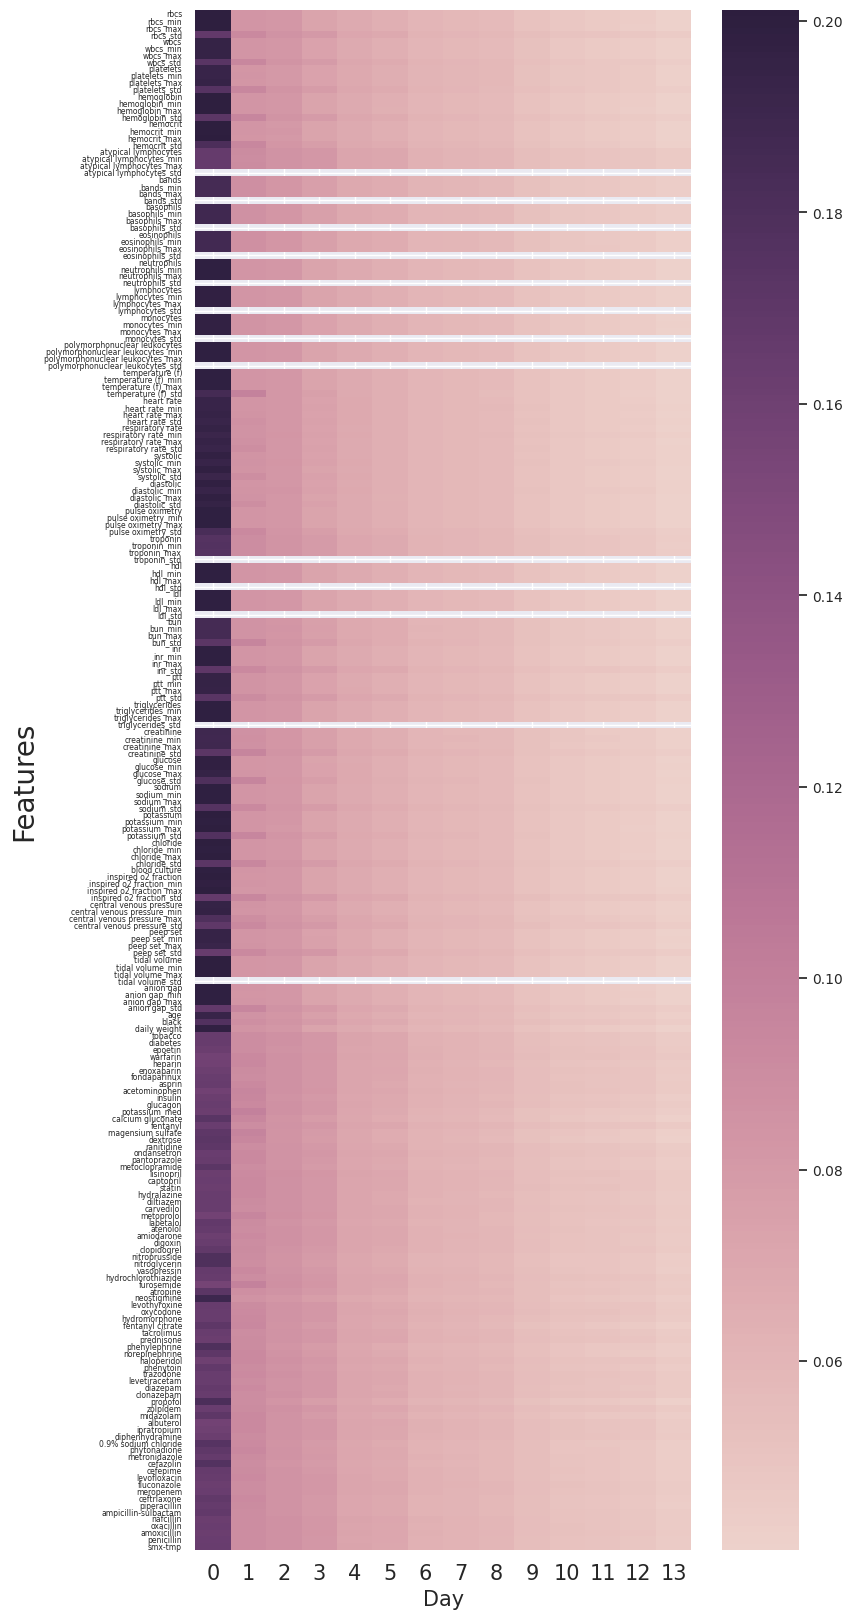

In [25]:
## GET HEATMAPS FOR ALL INCIDENTS AVERAGE ##

plt.figure(figsize = (8,20))

sns.set(font_scale = 0.5)

heatmap(np.nanmean(activations,axis=0).T[arranged_indices],
        square=False,
        yticklabels=np.array(features)[arranged_indices],
        cmap=my_cmap)
plt.gcf().axes[-1].tick_params(labelsize=10)
plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Features', fontsize=20)
# plt.savefig('./figures/heatmap_{0}_med_ranked_average_activation_Figure_3.eps'.format(target),
#             format='eps', dpi=300, bbox_inches='tight')

**Note**: Heatmap is attached at the end of the report pdf file due to the printing issue of Colab. See appendix A

## Model comparison

### Comparing metrics with results of original paper
* AUC Scores

In the original paper, the AUC score of VANCOMYCIN administration when trained with 100% data is 0.904. Our experiment shows AUC score as 0.917 which is slightly better than the original paper. <br>
In the original paper, the AUC score of 1 Day lag is 0.833. Our experiment shows the AUC score as 0.844 which is slightly better than the original paper.
<br>The AUC score results prove the Hypothesis 1 that the model can accurately predict daily clinical event vancomycin administration in the ICU.
<br><br>
* Heatmap

We also visually compare the heatmap with the original heatmap provided by the paper. It is very close. <br>The heatmap proves the Hypothesis 2 that the attention mechanism within the model provides interpretability by highlighting influential input variables that impact the model’s predictions.

## Ablation study

Ablation study 1: Reduce the LSTM units numbers from 256 to 128.

Result: after reducing input unit number from 256 to 128, the AUC score dropped to 0.907, below is a summary table of the AUC score with different percentage data. <br>
It indicates that more LSTM units can improve the training results.

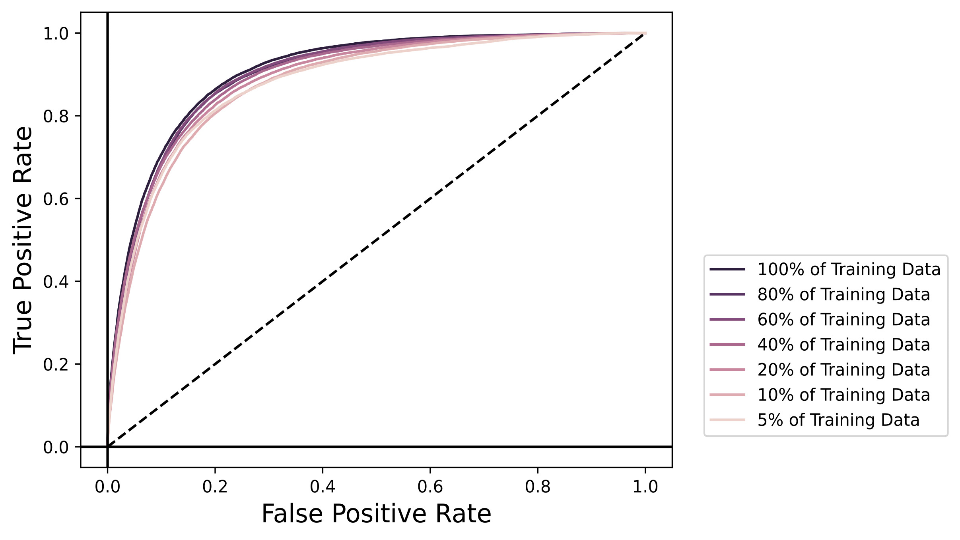

In [26]:
fig_dir = './discussion_results_figures/VANCOMYCIN_less_data_roc_curves_Supplemental_Figure_Reduced_input_size.jpg'
fig = cv2.imread(fig_dir)
fig = cv2.resize(fig, (960, 540))
cv2_imshow(fig)

**Note**: The curve is attached at the end of the report pdf file due to the printing issue of Colab. See appendix A

The AUC score of 100% data is 0.9074948499256059

The AUC score of 80% data is 0.8985577115684263

The AUC score of 60% data is 0.9000018127629131

The AUC score of 40% data is 0.8956845199163966

The AUC score of 20% data is 0.8871445775088873

The AUC score of 10% data is 0.8770589024582445

The AUC score of  5% data is 0.8779089189476184


PPV for full model is 0.6904868846568452

Sensitivity for full model is 0.71

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     67683
         1.0       0.69      0.71      0.70     21632

    accuracy                           0.85     89315
    macro avg      0.80      0.80      0.80     89315
    weighted avg   0.85      0.85      0.85     89315


Ablation study 2: Perform the ablation study by removing attention layer<br><br>

Result:
by removing the attention layer from training, the AUC score dropped to 0.905, below is a summary table of the AUC score.<br>
It indicates that attention layer can imporve the training results.

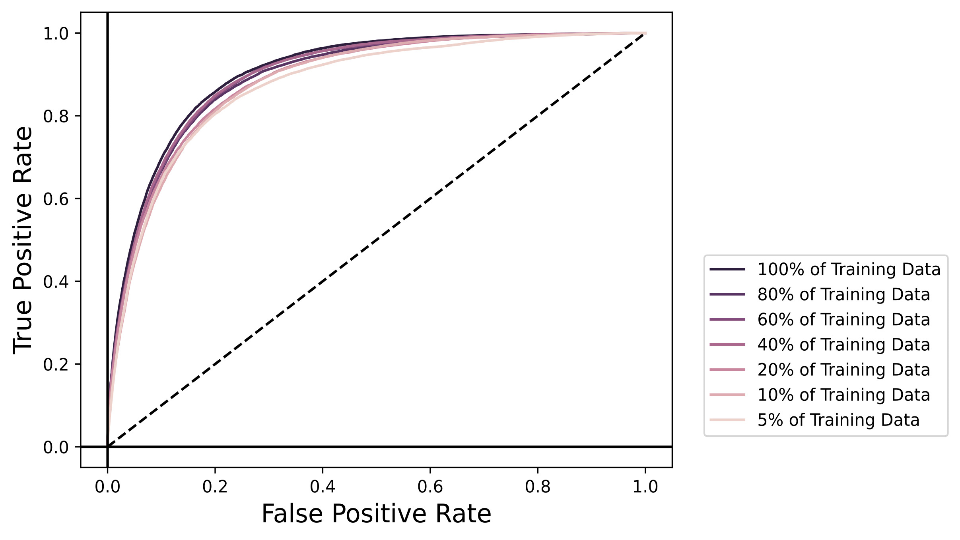

In [27]:
fig_dir = './discussion_results_figures/VANCOMYCIN_less_data_roc_curves_Supplemental_Figure_no_attention.jpg'
fig = cv2.imread(fig_dir)
fig = cv2.resize(fig, (960, 540))
cv2_imshow(fig)

**Note**: The curve is attached at the end of the report pdf file due to the printing issue of Colab. See appendix A

The AUC score of 100% data is 0.9055179403669401

The AUC score of 80% data is 0.8943403737626279

The AUC score of 60% data is 0.8971904972755931

The AUC score of 40% data is 0.8989405912558038

The AUC score of 20% data is 0.8872415571386091

The AUC score of 10% data is 0.8826029868174916

The AUC score of  5% data is 0.8748971620014971


PPV for full model is 0.679064028555061

Sensitivity for full model is 0.71

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     68129
         1.0       0.68      0.71      0.70     21600

    accuracy                           0.85     89729
    macro avg       0.79     0.80      0.80     89729
    weighted avg    0.85     0.85      0.85     89729

# Discussion

The paper is reproducible. We actually obtian slightly better training results than original paper's in terms of AUC score.




##"What was easy"
mimic data processing part was smooth and easy to follow
##"What was difficult"
It was quite chanllenging when we were trying to reproduce the result by running the notebook, some functions provided in original code was outdated and dependency python package structure has been changed. But we were able to manage and update the code and reproduce the orginal paper.
## Recommendations
To improve the reproducibility our recommendation to the original author and whoever is going to working in this area is listed below:
1. Create saved_model folder which will be used for saving training models in .h5 format.
2. Create pickled_objects folder and train sets txt files before hand since these file will be used for training sets and the training result will be dummped into these pre-created files
3. Create figure folder for gernating the metrics results
4. Keras model needs to updated where the old code no longer compatible
5. Use the latest Keras Activataion function from Phiipperemy keract github repository in order to get the heatmap working

# References

1. Kaji, D., Zech, J. R., Kim, J., Cho, S. K., Dangayach, N., Costa, A., & Oermann, E. K. (2019). An attention based deep learning model of clinical events in the intensive care unit. PLOS ONE, 14(2), e0211057. https://doi.org/10.1371/journal.pone.0211057
2. Keract: Keras Activations + Gradients (https://github.com/philipperemy/keract)



# Appendix A

Heatmap of all features

